In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GitHub/FL-project

/content/drive/MyDrive/GitHub/FL-project


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git remote add origin https://github.com/Mattizza/FL-project

In [1]:
!git clone https://github.com/Mattizza/FL-project

Cloning into 'FL-project'...
remote: Enumerating objects: 1786, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1786 (delta 26), reused 88 (delta 21), pack-reused 1688
Receiving objects: 100% (1786/1786), 509.58 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (1723/1723), done.


In [2]:
%cd FL-project

/content/FL-project


In [3]:
from main import *
import argparse
from centralized import Centralized
from client import *
from torch import optim, nn
from torch.optim import lr_scheduler
import numpy as np

In [4]:

# Class used to simplify the assignment of the arguments.
class Args():
  
  def __init__(self, dataset, model, bs, hnm, num_epochs):
    '''
    Class used to pass the-high level parameters
      -) dataset   : the dataset we are considering;
      -) model     : the model we are using;
      -) bs        : the batch size;
      -) num_epochs: number of epochs for which we will train the model.
    '''
    self.dataset = dataset    
    self.model = model      
    self.bs = bs             
    self.hnm = hnm
    self.num_epochs = num_epochs

args = Args(dataset = 'iddaCB', model = 'deeplabv3_mobilenetv2', 
            bs = 16, hnm = False, num_epochs = 2)

In [5]:

# We get the dataset and we create an instance of the model.
trainAloneDataset, testAloneDatasets = get_datasets(args)

ds    = trainAloneDataset[0]
model = model_init(args)


params freezed
epoch 0
epoch 1 / 2, step 10 / 37, loss = 0.187 ± 0.143
epoch 1 / 2, step 20 / 37, loss = 0.195 ± 0.143
epoch 1 / 2, step 30 / 37, loss = 0.183 ± 0.139
epoch 1 / 2, step 37 / 37, loss = 0.217 ± 0.157
epoch 1
epoch 2 / 2, step 10 / 37, loss = 0.189 ± 0.139
epoch 2 / 2, step 20 / 37, loss = 0.186 ± 0.148
epoch 2 / 2, step 30 / 37, loss = 0.212 ± 0.153
epoch 2 / 2, step 37 / 37, loss = 0.214 ± 0.156
Finish training
Model saved


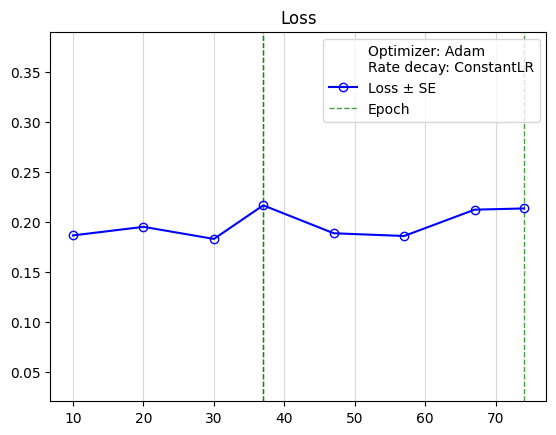

In [8]:

# In order to simulate the behaviour of our model, we simulate a centralized
# environment.
centralized = Centralized(args,ds,model)
state_dict  = torch.load('modelliSalvati/checkpoint.pth')
model.classifier.load_state_dict(state_dict)

# We pass to our centralized environment the optimization algorithm and the 
# rate decay technique. Finally, we train our model.

opt_params = {'optimizer': {
                            'name'    : 'Adam',
                            'settings': {'lr'   : np.random.choice(np.linspace(0.001, 0.1, 10000))}
                            },
              'scheduler': {
                            'name'    : 'ConstantLR',
                            'settings': {'factor': 0.33}
                            }
              }

centralized.set_opt(opt_params)
centralized.train_2()
centralized.print_learning(step = 10)


In [ ]:

# We import the metrics used to compute the goodness of our model and we test
# on our data.
from utils.stream_metrics import StreamSegMetrics
metric = StreamSegMetrics(16, 'centralizzato')
centralized.test(metric)


In [ ]:

# Here we can choose what kind of metric to show. Possible choices are:
#   -) Total samples    -) Mean IoU
#   -) Overall Acc      -) Class IoU
#   -) Mean Acc         -) Class Acc
#   -) Mean Precision   -) Class Prec
#   -) FreqW Acc 

metric.get_results()['Mean IoU']


In [ ]:

from torch.utils.data import DataLoader
train_loader = DataLoader(ds, batch_size = 2, shuffle = False, drop_last = True)


In [ ]:

centralized.model.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda() 
    labels = labels.cuda()
    outputs = centralized.model(images)['out']
    break


In [ ]:
outputs = centralized.model(images[0].view(1, 3, 512, 928))['out']

In [ ]:

import matplotlib.pyplot as plt
def unNormalize(tensorImage, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        for t, m, s in zip(tensorImage, mean, std):
            t.mul_(s).add_(m)
        return tensorImage
plt.imshow(unNormalize(images[0].cpu()).permute(1,2,0))


In [ ]:

singoloOutputLogits = outputs[0]
prediction = singoloOutputLogits.argmax(0)


In [ ]:

import matplotlib.pyplot as plt
plt.imshow(unNormalize(images[0].cpu()).permute(1,2,0))
plt.imshow(prediction.cpu().numpy(), alpha = 0.4)


In [ ]:

import matplotlib as mpl

plt.imshow(labels[0].cpu().numpy(), cmap = mpl.colormaps['inferno'], vmin = 0, vmax = 16)
